# Simple CSTR State-estimation: MHE
(By David T)

### 0. Introduction
In this example, the state-estimation of a simple CSTR reactor is demonstrated with the *CAPRESE* tools. For this model, a non-isothermal CSTR model is used. The kinetics represent the reaction between thiosulfate and hydrogen peroxide,
\begin{align}
\dfrac{dC_{A}}{dt} &= \dfrac{F}{V} \left(C_{A}^{in} - C_{A} \right) - 2k T_{R}C_{A}^{2} \\
\dfrac{dT_{R}}{dt} &= \dfrac{F}{V} \left(T_{R}^{in} - T_{R} \right) + \dfrac{2 \left(- \Delta H_{R} \right)k T_{R} C_{A}^{2}}{\rho C_{p}} - \dfrac{UA}{V \rho C_{p}} \left(T_{R} - T_{cw} \right) \\
\dfrac{dT_{cw}}{dt} &= \dfrac{F_{cw}}{V_{cw}} \left(T_{cw}^{in} - T_{cw} \right) + \dfrac{2 \left(- \Delta H_{R} \right)k T_{R} C_{A}^{2}}{\rho C_{p}} - \dfrac{UA}{V \rho C_{p}} \left(T_{R} - T_{cw} \right) \\
k \left(T_{R} \right) &= k_{0} \exp \left(\dfrac{-E_{a}}{RT_{R}} \right)
\end{align}
Where $C_{A}$ is the concentration of thiosulfate, $T_{R}$ is the reactor temperature and the cooling water temperature $T_{cw}$.  
For this problem, a simple MHE strategy will be used, that is a formulation as follows:
begin{equation} 
 \begin{split}
 \min_{x_{-\mathcal{N}},\mathbf{w}_{k}, \mathbf{v}_{k}} \quad & \Phi_{-\mathcal{N}} \left(x_{-\mathcal{N}|k}, x_{-\mathcal{N}|k-1}, \Pi _{-\mathcal{N}|k-1}\right)+  \\ &        \quad  +  \sum_{i=-\mathcal{N}}^{0} v_{i|k}^{T} \mathcal{R}^{-1}_{i} v_{i|k} + \sum_{i=-\mathcal{N}}^{-1}w^{T}_{i|k} \mathcal{Q}^{-1}_{i} w_{i|k}\\
 \text{s.t.} \quad  &x_{l+1|k} = f \left(x_{l|k}\right) + w_{l|k}, \quad l \in \left\lbrace -\mathcal{N},-\mathcal{N}+1,...,-1 \right\rbrace\\
 &y\left(k+l\right) = h \left(x_{l|k}\right) + v_{l|k}, \quad   l \in \left\lbrace -\mathcal{N},-\mathcal{N}+1,...,0 \right\rbrace\\
 &x_{l|k} \in \mathbb{X}, \quad l \in \left\lbrace -\mathcal{N},-\mathcal{N}+1,...,0 \right\rbrace\\
 &w_{l|k} \in \mathbb{W}, \quad l \in \left\lbrace -\mathcal{N},-\mathcal{N}+1,...,-1 \right\rbrace,\\
 \end{split}
 \end{equation}

where, $x$ correspond to states, $y$ the measurements, $v$ the measurement noise, and $w$ the plant disturbance.

### 1. MHE object set up

In [87]:
from nmpc_mhe.aux.utils import load_iguess
from nmpc_mhe.aux.utils import reconcile_nvars_mequations  #: counts n_var and m_equations from nl
from nmpc_mhe.pyomo_dae.MHEGen_pyDAE import MheGen_DAE
from sample_mods.cstr_rodrigo.cstr_c_nmpc import cstr_rodrigo_dae
from pyomo.environ import *
import matplotlib.pyplot as plt
import os, sys

With similar ideas in mind as the NMPC object set-up, a predefined model needs to have the appropiate ports for controls. Therefore, for the specific MHE problem, it is necesary to define the measurement variables.

In [88]:
measurements = ['T']

The remaining information corresponds to the state and control information. For this example it is declared to keep consistency.

In [89]:
states = ["Ca", "T", "Tj"]
controls = ["u1"]
u_bounds = {"u1": (200, 1000)}
state_bounds = {"Ca": (0.0, None), "T":(2.0E+02, None), "Tj":(2.0E+02, None)}
ref_state = {("Ca", (0,)): 0.010}

In [90]:
mod = cstr_rodrigo_dae(2,2)

In this way the MHE object can be created. 

In [91]:
e = MheGen_DAE(mod, 2, states, controls, states, measurements,
               u_bounds=u_bounds,
               ref_state=ref_state,
               override_solver_check=True,
               var_bounds=state_bounds,
               k_aug_executable='/home/dav0/in_dev_/WorkshopFraunHofer/caprese/k_aug/bin/k_aug')

New model at 139910157709392
New timebounds defined!
New model at 139910246423360
New timebounds defined!
Model: unknown Bounds activated
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
New model at 139910155618096
New model at 139910157736528
New timebounds defined!
New timebounds defined!
Model: LSMHE (Least-Squares MHE) Bounds activated


W0[[Initializing MHE]]The Q_MHE and R_MHE matrices are diagonal.


The MHE problem requires more information to be constructed.

In [92]:
#: We need k_aug to run this :(
Q = {}
U = {}
R = {}
Q['Ca'] = 1.11
Q['T'] = 99.0
Q['Tj'] = 1.1
U['u1'] = 0.22
R['T'] = 1.22
e.set_covariance_disturb(Q)
e.set_covariance_u(U)
e.set_covariance_meas(R)
e.lsmhe.Q_mhe.pprint()
e.lsmhe.R_mhe.pprint()
e.lsmhe.U_mhe.pprint()
e.create_rh_sfx()

Q_mhe : Size=12, Index=Q_mhe_index, Domain=Any, Default=None, Mutable=True
    Key    : Value
    (0, 0) :   0.9009009009009008
    (0, 1) : 0.010101010101010102
    (0, 2) :   0.9090909090909091
    (1, 0) :   0.9009009009009008
    (1, 1) : 0.010101010101010102
    (1, 2) :   0.9090909090909091
    (2, 0) :   0.9009009009009008
    (2, 1) : 0.010101010101010102
    (2, 2) :   0.9090909090909091
    (3, 0) :   0.9009009009009008
    (3, 1) : 0.010101010101010102
    (3, 2) :   0.9090909090909091
R_mhe : Size=5, Index=R_mhe_index, Domain=Any, Default=None, Mutable=True
    Key    : Value
    (0, 0) : 0.819672131147541
    (1, 0) : 0.819672131147541
    (2, 0) : 0.819672131147541
    (3, 0) : 0.819672131147541
    (4, 0) : 0.819672131147541
U_mhe : Size=5, Index=U_mhe_index, Domain=Any, Default=None, Mutable=True
    Key       : Value
    (0, 'u1') : 4.545454545454546
    (1, 'u1') : 4.545454545454546
    (2, 'u1') : 4.545454545454546
    (3, 'u1') : 4.545454545454546
    (4, 'u1') : 4.

In [93]:
e.get_state_vars()
e.load_iguess_steady()
load_iguess(e.SteadyRef, e.PlantSample, 0, 0)
e.solve_dyn(e.PlantSample)

{'Ca': [(0,)], 'T': [(0,)], 'Tj': [(0,)]}
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_steady_ref]]labels at 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]SteadyRef.--------------------
/tmp/tmpbocy_ci5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                              bound_push = 1e-07                 yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251101.846347vanilla0  yes
            

optimal


/tmp/tmpjnwh2r8j.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251101.915026vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


0

In [94]:
e.init_lsmhe_prep(e.PlantSample)
e.shift_mhe()
e.init_step_mhe()
e.solve_dyn(e.lsmhe,
            skip_update=False,
            max_cpu_time=600,
            ma57_pre_alloc=5, tag="lsmhe")  #: Pre-loaded mhe solve

-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[init_lsmhe_prep]]Preparation phase MHE.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_init_state_gen]]Load State to nmpc src_kind=mod.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]Measurement to:0.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpx68_us_t.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 y

optimal


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251102.056427vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of var

optimal


/tmp/tmpwf90vohg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251102.112755vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 2
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]Measurement to:3.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpz8p596w3.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251102.177023vanilla

optimal


/tmp/tmpmyzluaws.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251102.246932vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Preparation MHE.--------------------
/tmp/tmpeblxytmu.pyomo.nl -AMPL halt_on_ampl_error=yes 
Ipopt vanilla0: halt_on_ampl_error=yes
halt_on_ampl_error=yes


List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 1e-06                 yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 5                     yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[initialize_lsmhe]]Attempting to initialize lsmhe Done.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmprs0is8jq.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpybwz42_u.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 5                     yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 3000                  yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_

optimal


0

In [95]:
e.check_active_bound_noisy()
e.load_covariance_prior()
e.set_state_covariance()

-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.4993; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 129
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 17
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601034229527142 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033361066351 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 129, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 513
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 67
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000000
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 94
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


In [96]:
e.regen_objective_fun()  #: Regen erate the obj fun
e.deact_icc_mhe()  #: bRemove the initial conditions

In [97]:
ca = e.PlantSample.Ca[2, 0]
t = e.PlantSample.T[2, 0]
u = e.PlantSample.u1[2]
tj = e.PlantSample.Tj[2, 0]

ca_mhe = e.lsmhe.Ca[10, 0]
t_mhe = e.lsmhe.T[10, 0]
tj_mhe = e.lsmhe.Tj[10, 0]

spl = []
ul = []
cal = []
tl = []
tjl = []

ca_mhel = []
t_mhel = []
tj_mhel = []

In [98]:
for i in range(0, 60):  #: Five steps
    if i < 20:
        sigma = 0.0005
    elif 20 < i < 40:
        sigma = 0.0015
    else:
        sigma = 0.002
    e.noisy_plant_manager(sigma=sigma, action="apply", update_level=True)
    e.solve_dyn(e.PlantSample, stop_if_nopt=True)
    cal.append(value(ca))
    tl.append(value(t))
    tjl.append(value(u))
    e.update_state_real()  # update the current state
    e.update_measurement()
    e.compute_y_offset()  #: Get the offset for y
    e.preparation_phase_mhe(as_strategy=False)

    stat = e.solve_dyn(e.lsmhe,
                       skip_update=False, iter_max=500,
                       jacobian_regularization_value=1e-04,
                       max_cpu_time=600, tag="lsmhe", keepsolve=False, wantparams=False)

    if stat == 1:  #: Try again
        e.lsmhe.write_nl(name="bad_mhe.nl")
        stat = e.solve_dyn(e.lsmhe,
                           skip_update=True,
                           max_cpu_time=600,
                           stop_if_nopt=True,
                           jacobian_regularization_value=1e-02,
                           linear_scaling_on_demand=True, tag="lsmhe")
        if stat != 0:
            sys.exit()
    e.update_state_mhe()  #: get the state from mhe
    ca_mhel.append(value(ca_mhe))
    t_mhel.append(value(t_mhe))
    tj_mhel.append(value(tj_mhe))
    #: At this point computing and loading the Covariance is not going to affect the sens update of MHE
    e.prior_phase()
    e.print_r_mhe()
    e.print_r_dyn()

-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpcxqdal97.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251102.740690vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpbys9c218.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp8yn0iper.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.829443; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-4.695417101885647 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-4.695417101885635 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 43810.239175
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpk50bbm23.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251103.129038vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp1e6vgp1b.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpx_ap32i_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.0652663; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033487779775 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601034346231046 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000052
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251103.471030vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


/tmp/tmp2kkxcjvt.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmppf72b6jw.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.490581; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033726395178 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303011274 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000326
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251103.821299vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpzazl9sew.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpetxk8w_d.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.491516; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727254862 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303018324 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000092
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251104.159715vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables..........................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp2gcfhgvn.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.509019; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727151783 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033302792095 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000034
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.72e-02 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 s


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmphqeftzo5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpsmzn782h.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.499727; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727161166 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103330292814 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000019
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpgs2oc5x6.pyomo.nl -AMPL 


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmput922v20.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpnv3k6x56.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.569989; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103372638763 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103330191212 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000069
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251105.083714vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpf68l6bkn.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpknk68rm4.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.54191; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033726560647 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033302196452 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000028
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251105.456082vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.......

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp_83r7jwp.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.507644; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727021631 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033302765865 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000255
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251105.802697vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpnyxqc75d.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpmjeftm4e.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.526535; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103372675834 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033302329705 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000299
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmp80qcm_ym.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251106.095435vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


/tmp/tmp5usfldry.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpkdztcbv5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.46186; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727609538 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103330349381 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000065
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpk5rpy1ok.pyomo.nl -AMPL 


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpzsltu8sg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp7jl3pkr2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.506357; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727239825 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033302954086 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000186
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpbbrxwnyw.pyomo.nl -AMPL 


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpuxdh4s3d.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp_90i15ab.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.542521; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033726692064 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033302374667 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000108
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmp6abs6q3_.pyomo.nl -AMPL 


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpw2sj9ezu.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpat0p1vq6.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.568898; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033726250979 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033301780282 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000208
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251107.341430vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp38qt897p.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpw7o7f7gd.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.513518; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033726846742 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033302646927 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000039
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251107.672058vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of var

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmphmtk7vyz.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp40kr97v4.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.536181; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033726530332 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103330211114 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000169
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpzrej_hys.pyomo.nl -AMPL 


optimal


/tmp/tmpfvlw_8jo.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpfokb08nc.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.516223; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033726855192 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033302601191 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000004
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251108.306468vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables.....................

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp_3mt7bn7.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpxx66mi7n.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.561758; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033726271769 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033301847936 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000026
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251108.642022vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpfjdro561.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp0_gz42cp.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.485897; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033726930039 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033302870114 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000075
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251108.968114vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpk4x4h2bk.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpt3yvi940.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.583855; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103372636258 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033301771302 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.000144
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251109.316634vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmptrpmmuan.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.479568; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103372736605 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033303181037 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.001476
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpg0s8gvsn.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251109.608412vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


/tmp/tmpku538acg.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpr7sksnqw.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.512681; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727075142 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033302788089 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.003592
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251109.890494vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constrain

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpdv7yub61.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.488514; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033727237851 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033302939932 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.006472
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmp4v5965yt.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251110.191310vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmprpd4b11a.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpjh6_inz7.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.308874; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103372852489 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103330479956 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.009090
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19 

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmp3ujlw999.pyomo.nl -AMPL 


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpo490zrzi.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = ye

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpi9cr51vt.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.598919; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033726419066 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033301988386 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.004718
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpuzgda6ad.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251110.820896vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


/tmp/tmpe7g3zskc.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpflc0zyqb.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.619667; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033724932043 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033300436162 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.003096
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmp3qmgjs2c.pyomo.nl -AMPL 


optimal


/tmp/tmphzw5cg2a.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpqbam4arf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.616368; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033724090044 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033299690457 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.003989
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmpk59ekfef.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251111.409068vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpc45yp5do.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp3gbj9k5k.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.64554; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033722625335 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103329788473 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.006205
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmplcd8i7n2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251111.704630vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


/tmp/tmpojdhxska.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpn8zpsj34.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.636659; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033723581118 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033299122529 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.009363
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmprt9avi4k.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251111.995674vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.......

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp5c3w4gyk.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.616062; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033724556459 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033300331663 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.011044
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251112.274579vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpaq4to_pr.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.615889; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033724521686 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033300242126 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.006502
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmp9uyv1yft.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251112.559190vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


/tmp/tmppsnc8b8e.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp0658q1zz.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.622066; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033723920153 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033299450911 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.005909
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpi5ahznjs.pyomo.nl -AMPL 


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp1eg6qc2h.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp_mqjgbh4.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.621195; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033723159334 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103329875656 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.007559
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251113.195600vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.......

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpzd037x8k.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.643642; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033722022223 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103329736101 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.010537
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251113.523157vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpn4v46iqh.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp4wgylyqm.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.630466; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103372309276 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033298759864 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.007169
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpn4i9s4kj.pyomo.nl -AMPL 


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpbjzoywhk.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpa6_4t62v.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.628641; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033723565536 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033299149853 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.004766
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251114.188328vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.......

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpjj1n6911.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.617968; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033723507827 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033299206607 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.007292
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251114.512580vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp9jpgkg43.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpczy32yvd.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.633321; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033722511314 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033297869147 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.017874
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                             output_file = 1568251114.850838vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequalit

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmplqr_58c7.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = ye

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp0v4oaa7a.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.63373; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033722857258 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033298515702 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.013505
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value



List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251115.174190vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of va

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpi8pzgzpu.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpxhrahz3v.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.629423; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033723695938 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033299349456 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.004393
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmps9ccutik.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251115.471662vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp9r_0_sc3.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.607433; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103372411425 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033299914786 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.003956
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmpksnl93mr.pyomo.nl -AMPL 


optimal


/tmp/tmpdtuhap8s.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpbosan757.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.636011; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103372157836 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033296718068 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.004023
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251116.085043vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of var

optimal


/tmp/tmpsoy6rjbm.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmplb1_jfki.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.626763; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033720843352 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033295881004 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.005858
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmp0k78ih6q.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251116.456357vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpr9ltechp.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       73

Total number of variables............................:      146
                     variables with only lower bounds:       48
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      126
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.110843

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.624059; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033723486168 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033299326305 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.013851
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251116.865682vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpf8mpq4v7.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpwmv37fg5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.616415; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033724274787 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033300073654 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.023519
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.58e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 s
   1  0.0000000e+00 1.89e-02 0.00e+00  -1.0 9.98e+01    -  1.00e+00 1.00e+00H  1 
   2  0.0000000e+00 3.05e-07 0.00e+00  -3.8 2.59e-02    -  1.00e+00 1.00e+00h  1 Nhj A
   3  0.0000000e+00 7.73e-12 0.00e+00  -8.6 2.98e-07    -  1.00e+00 1.00e+00h  1 

Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   7.7307049650698900e-12    7.7307049650698900e

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpnr4ta3ii.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpq8pnv6m2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.619099; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033724474709 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033300150526 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.005907
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251117.643744vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpge9mbrey.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


/tmp/tmplenzah8v.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.620737; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033724016707 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033299528368 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.004739
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251118.006540vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpbqyc4sy7.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp_zpqj605.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.607876; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033723141974 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033299006485 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.007657
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251118.320867vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
To

optimal


/tmp/tmp7p70yg4d.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp0akcjoyw.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.687042; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033719385693 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033293977395 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.013767
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251118.650660vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpzwo2q10m.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt       

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpor_8sq28.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.63181; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033722632229 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033298483785 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.011349
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]PlantSample.--------------------
/tmp/tmp5c9ht7xg.pyomo.nl -AMPL 


optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpc4pcxsk0.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


/tmp/tmpgeedto9t.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.617592; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033723984715 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033299684481 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.019283
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


/tmp/tmp8kl5rx0n.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251119.338750vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp3iqf18j5.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp3b60ydf7.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.605622; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033724070218 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033299942259 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.009763
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                                max_iter = 3000                  yes
                             output_file = 1568251119.668829vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequalit

optimal


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp01ja45vy.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.653472; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033721595902 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033296627918 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.007328
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251119.919413vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmptrf3t5vp.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmppc3qrbz2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.609099; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033722888197 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.60103329876571 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.017937
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251120.182765vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower boun

optimal


        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.......

optimal


/tmp/tmp_v52nbca.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500                   yes
                             output_file = lsmhe_log.log         yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:      510
Number of nonzeros in inequality 

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.641296; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103372078451 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033295886449 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.030483
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.94e-01 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0 s
   1  0.0000000e+00 6.42e-01 0.00e+00  -1.7 4.30e+01    -  1.00e+00 1.00e+00h  1 
   2  0.0000000e+00 2.67e-05 0.00e+00  -1.7 6.07e-01    -  1.00e+00 1.00e+00h  1 Nhj A
   3  0.0000000e+00 2.27e-12 0.00e+00  -8.6 1.96e-05    -  1.00e+00 1.00e+00h  1 

Number of Iterations....: 3

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   0.0000000000000000e+00    0.0000000000000000e+00
Constraint violation....:   2.2737367544323206e-12    2.2737367544323206e

optimal


/tmp/tmp_87cs1yk.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpk5auk3vl.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.640424; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.60103372184582 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033297428764 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.019364
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC19

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251120.769124vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
To

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp0tx9fdec.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = ye

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmp2e9veuzj.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.608245; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033723527062 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033299371533 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.035362
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251121.153511vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmpbvpu7mo2.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpa_tdhend.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.607154; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033722642153 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033298538196 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.024341
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251121.413877vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:  

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[patch_meas_mhe]]use_dict.--------------------
fetgt 1 0
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]Dummy[MHE].--------------------
/tmp/tmp44bkjkcj.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
    

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpkwfqeya0.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[load_covariance_prior]]K_AUG w red_hess.--------------------


W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.662466; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033718670186 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033293252767 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.028017
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 1e+06                 yes
                                max_iter = 3000                  yes
                             output_file = 1568251121.672909vanilla0  yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:       94
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:       28
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       28
To

optimal


/tmp/tmpxasj4wi_.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
        jacobian_regularization_exponent = 2                     yes
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 300                   yes
                                max_iter = 3000                  yes
                             output_file = init_mhe.txt          yes
                       print_info_string = yes                   yes
                      print_user_options = yes                   yes
This is Ipopt version vanilla0, running with linear solver ma57.

Number of nonzeros in equali

optimal


-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[solve_dyn]] Model solved to optimality.--------------------
fetgt 5 4
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[preparation_phase_mhe]]idMHE: Ready.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[Solving with IPOPT	]]LSMHE (Least-Squares MHE).--------------------
/tmp/tmpju8k7awf.pyomo.nl -AMPL 
Ipopt vanilla0: 

List of user-set options:

                                    Name   Value                used
           jacobian_regularization_value = 0.0001                yes
                           linear_solver = ma57                  yes
                  ma57_automatic_scaling = no                    yes
                          ma57_pre_alloc = 1.5                   yes
                   ma57_small_pivot_flag = 0                     yes
                            max_cpu_time = 600                   yes
                                max_iter = 500   

optimal
W[K_AUG]...	[K_AUG_ASL]No n_rhs declared
W[K_AUG]...	[K_AUG_ASL]Target log10mu:= -11.
W[K_AUG_ASL]...	[K_AUG_ASL]No ipopt_zU_out suffix declared, setting zU = 0.
W[K_AUG]...	[K_AUG_ASL]No f_timestamp suffix declared, Fallback to default writing mode.
I[K_AUG]...	[K_AUG_ASL] Filename for dot_sens dot_in_.in
E[K_AUG]...	[MA57_DRIVER]

		Could not fix the accuracy of the problem.
		Try re-writing the problem or give a different point or change "max_refinement_steps"
		Current residual ratio 0.608759; Max residual ratio 1e-10.

W[K_AUG]...	[K_AUG_ASL]Evaluating the inverse of the solution matrix. 
I[K_AUG]...	[DPOTRI_DRIVER] Output file name inv_.in


[K_AUG] written by D.T. @2018

: compute_inv=
compute_inv=
I[K_AUG]...	[K_AUG_ASL]File read succesfull
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides 0
I[K_AUG]...	[K_AUG_ASL]Number of Right hand sides: 0
I[K_AUG]...	[K_AUG_ASL]Number of variables       : 146
I[K_AUG]...	[K_AUG_ASL]Number of constraints     : 126
I[K_AUG]...	[K_AUG_ASL]Number of valid n_dof     : 20
I[K_AUG]...	[ADJUST_MU]log10(mu) computed=-8.601033721334801 at var_i=0
I[K_AUG]...	[ADJUST_MU]log10(mu) close to the target	-8.601033297544006 at var_i=1
I[K_AUG]...	[FIND_INEQUALITIES]summary: eq: 126, leq: 0, geq: 0 
I[K_AUG]...	[K_AUG_ASL]Nonzeroes in the sparse Jacobian 510
I[K_AUG]...	[GET_HESS_ASL]Objective found
I[K_AUG]...	[GET_HESS_ASL]Nonzeroes in the sparse hessian 73
I[K_AUG]...	[GET_HESS_ASL]Minimization problem detected
I[K_AUG]...	[GET_HESS_ASL]Current objective 0.025849
I[K_AUG]...	[GET_HESS_ASL]Missing nz in the Hessian of the Lag: 91
I[K_AUG]...	[K_AUG_ASL]Barrier term added.
I[K_AUG]...	[K_AUG_ASL]MC1

f_timestamp : Direction=Suffix.EXPORT, Datatype=Suffix.INT
    Key : Value


------------------------------------------------------------------------------------------------------------------------
I[[load covariance]] e-states nrows 3 ncols 3
------------------------------------------------------------------------------------------------------------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_mhe]]Results suffix 1568251101.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results at/home/dav0/in_dev_/WorkshopFraunHofer/caprese.--------------------
-==--==--==--==--==--==--==--==--==--==--==--==--==--==--==-
I0[[print_r_dyn]]Results suffix 1568251101.--------------------


In [99]:
print(len(ca_mhel), len(cal))

60 60


In [100]:
err_ca = [abs(ca_mhel[i] - cal[i])/cal[i] for i in range(0, len(cal))]
err_t = [abs(t_mhel[i] - tl[i])/tl[i] for i in range(0, len(tl))]
err_tj = [abs(tj_mhel[i] - tjl[i])/tjl[i] for i in range(0, len(tjl))]

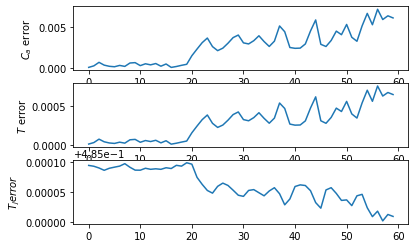

In [101]:
ax1 = plt.subplot(3, 1, 1)
plt.plot(err_ca)
plt.ylabel("$C_{a}$ error")

plt.subplot(3, 1, 2, sharex=ax1)
plt.plot(err_t)
plt.ylabel("$T$ error")


plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(err_tj)
plt.ylabel("$T_{j} error$")
#plt.title("Control input")
plt.show()
plt.show()